In [1]:
import os
import sys
import glob
import numpy as np
import scipy.optimize    as op
import matplotlib.pyplot as plt
import urllib.request
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from astropy.table import vstack
from numpy.fft import rfft, rfftfreq

In [16]:
eBOSScat = fits.open('/home/holman/FILES/BALsamDR14.fits')[1]
eBOSS = Table.read(eBOSScat)
DLAcat = fits.open('/home/holman/FILES/DLA_DR14CorRa.fits')
DLAs = Table.read(DLAcat)

In [74]:
#spec-7339-56799-0379_sample.fits
eBOSS[(eBOSS['PLATE']==5429) & (eBOSS['MJD']==55979) & (eBOSS['FIBERID']==108)]
#eBOSS[(eBOSS['Z']>3.6)&(eBOSS['BI_CIV']<=0)&(eBOSS['PLATE']==7147)]

SDSS_NAME,RA,DEC,THING_ID,PLATE,MJD,FIBERID,SPECTRO,Z,Z_ERR,SOURCE_Z,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,SPECTRO_DUPLICATE,BI_CIV,ERR_BI_CIV,RUN_NUMBER,RERUN_NUMBER,COL_NUMBER,FIELD_NUMBER,OBJ_ID,PSFFLUX,IVAR_PSFFLUX,PSFMAG,ERR_PSFMAG,MI,GAL_EXT,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,CC_FLAGS,PH_FLAGS,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP
-,deg,deg,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,km / s,km / s,-,-,-,-,-,nanomaggies,-,mag,mag,-,mag,counts/s,-,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / s,arcsec,-,-,-,-,-,Vega,Vega,-,-,Vega,Vega,-,-,Vega,Vega,-,-,arcsec,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,arcsec,-,W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),W / (Hz m2),-,mJy,-,arcsec
str18,float64,float64,int32,int16,int32,int16,str4,float64,float64,str4,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32[51],int32[51],int32[51],str1[51],float64,float64,int16,str1,int16,int16,str1,float64[5],float64[5],float64[5],float64[5],float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str4,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
132611.84+074358.3,201.5493720776801,7.732884828941669,180259344,5429,55979,108,BOSS,4.115,0.0,VI,4.114999771118163,4.111790657043457,0.0002349554270040244,0,4.101598,-1.0,-1.0,4096,8388608,0,0,0,0,1,0,1,0 .. -1,0 .. -1,0 .. -1,- .. -,0.0,0.0,0,-,0,0,-,0.13899219036102295 .. 109.13131713867188,26.191423416137695 .. 0.28591474890708923,24.11570930480957 .. 17.40507698059082,0.678665280342102 .. 0.018604444339871407,-29.997314000000006,0.10915997624397278 .. 0.03252395987510681,0.0,0.0,-1.0,3.205264000000001e-14,2.0000201e-15,4.2468802e-14,5.48176e-15,7.482539999999998e-14,4.325780000000001e-15,1.2926159124924757e+46,0.055081839681450674,1.0,0.19252175092697146,42.81031681669828,0.08868949115276338,11.422618154015105,16.237000000000002,0.103,9.7,2,15.322,0.08800000000000001,12.7,2,14.907,0.127,8.3,2,0.066314,13.618,0.025,43.29999923706055,0.8859,13.15,0.029,36.900001525878906,0.9547,10.298,0.07,15.5,1.003,8.23,0.025,4.300000190734863,0.9236,0000,AAAB,0.059691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0


In [18]:
#np.n1d np.intersect1d
match = np.in1d(np.array(DLAs['THING_ID']),np.array(eBOSS['THING_ID']))
intersect = DLAs[match]
#to_plot = intersect[(intersect['NHI']>=21) & (intersect['NHI']<=21.5) & (intersect['CNR']>=15) & (intersect['Z']>=3.2)]
to_plot = intersect[(intersect['MJD-PLATE-FIBER']=='55746-04987-0672')]

to_plot

THING_ID,MJD-PLATE-FIBER,RA,DEC,ZQSO,fDLA,fBAL,BI,CNR,Z,NHI,cc,log(Pcc),saap,Dcore,Pcore,Fcore,Ecore,Ccore,fg,CII_1334,b1,SiII_1526,b2,FeII_1608,b3,AlII_1670,b4,FeII_2344,b5,FeII_2374,b6,FeII_2382,b7,FeII_2586,b8,FeII_2600,b9,MgII_2796,b10,MgII_2803,b11,MgI_2852,b12
int32,str16,float64,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,str6,str6,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
404076921,55746-04987-0672,253.53407,35.1653,2.853,1,0,-1,15.6,2.4087,21.13,0.834,-25.82,0.33,0.143,0.652,0.248,0.574,11.168,0,0.0,0.0,0.41,0.04,0.23,-1.0,0.14,-1.0,0.36,-1.0,0.3,0.09,0.26,0.08,0.94,-1.0,0.93,-1.0,0.79,-1.0,1.01,-1.0,1.14,-1.0


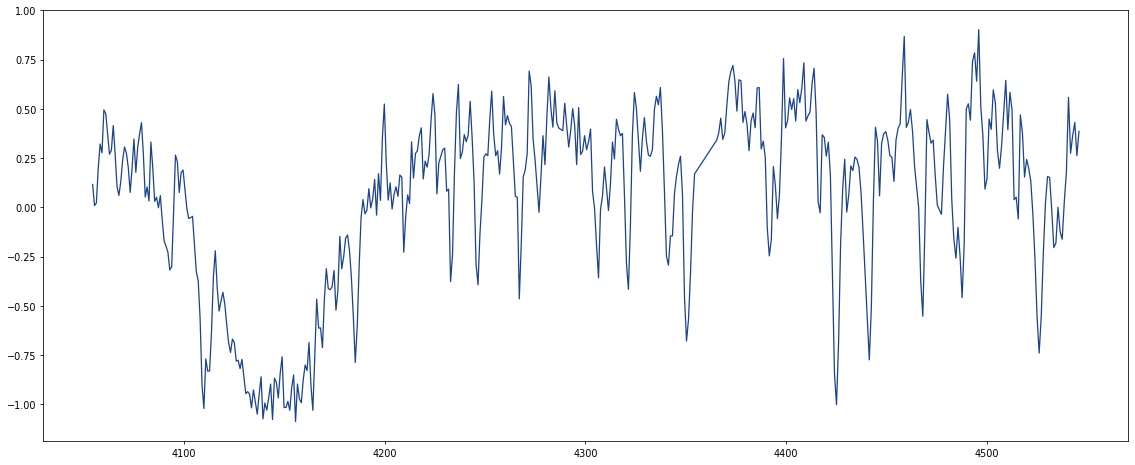

In [58]:
df_list = os.listdir('/home/holman/FILES/') # df_list = Downloaded files (Excluding catalogs)
df_list.sort()
df_list = np.array(df_list)
fi_f = np.char.find(df_list, "DLAnocor", start=0, end=None)
delta_name = '/home/holman/FILES/' + str(df_list[fi_f>=0])[2:24]
delta_file = fits.open(delta_name)[276]
DELTA = Table.read(delta_file)
plt.figure(figsize=(20,8),dpi=70)
plt.plot(10**DELTA['LOGLAM'],DELTA['DELTA'],label = 'Delta',lw=1.3, color ='#1C448E')

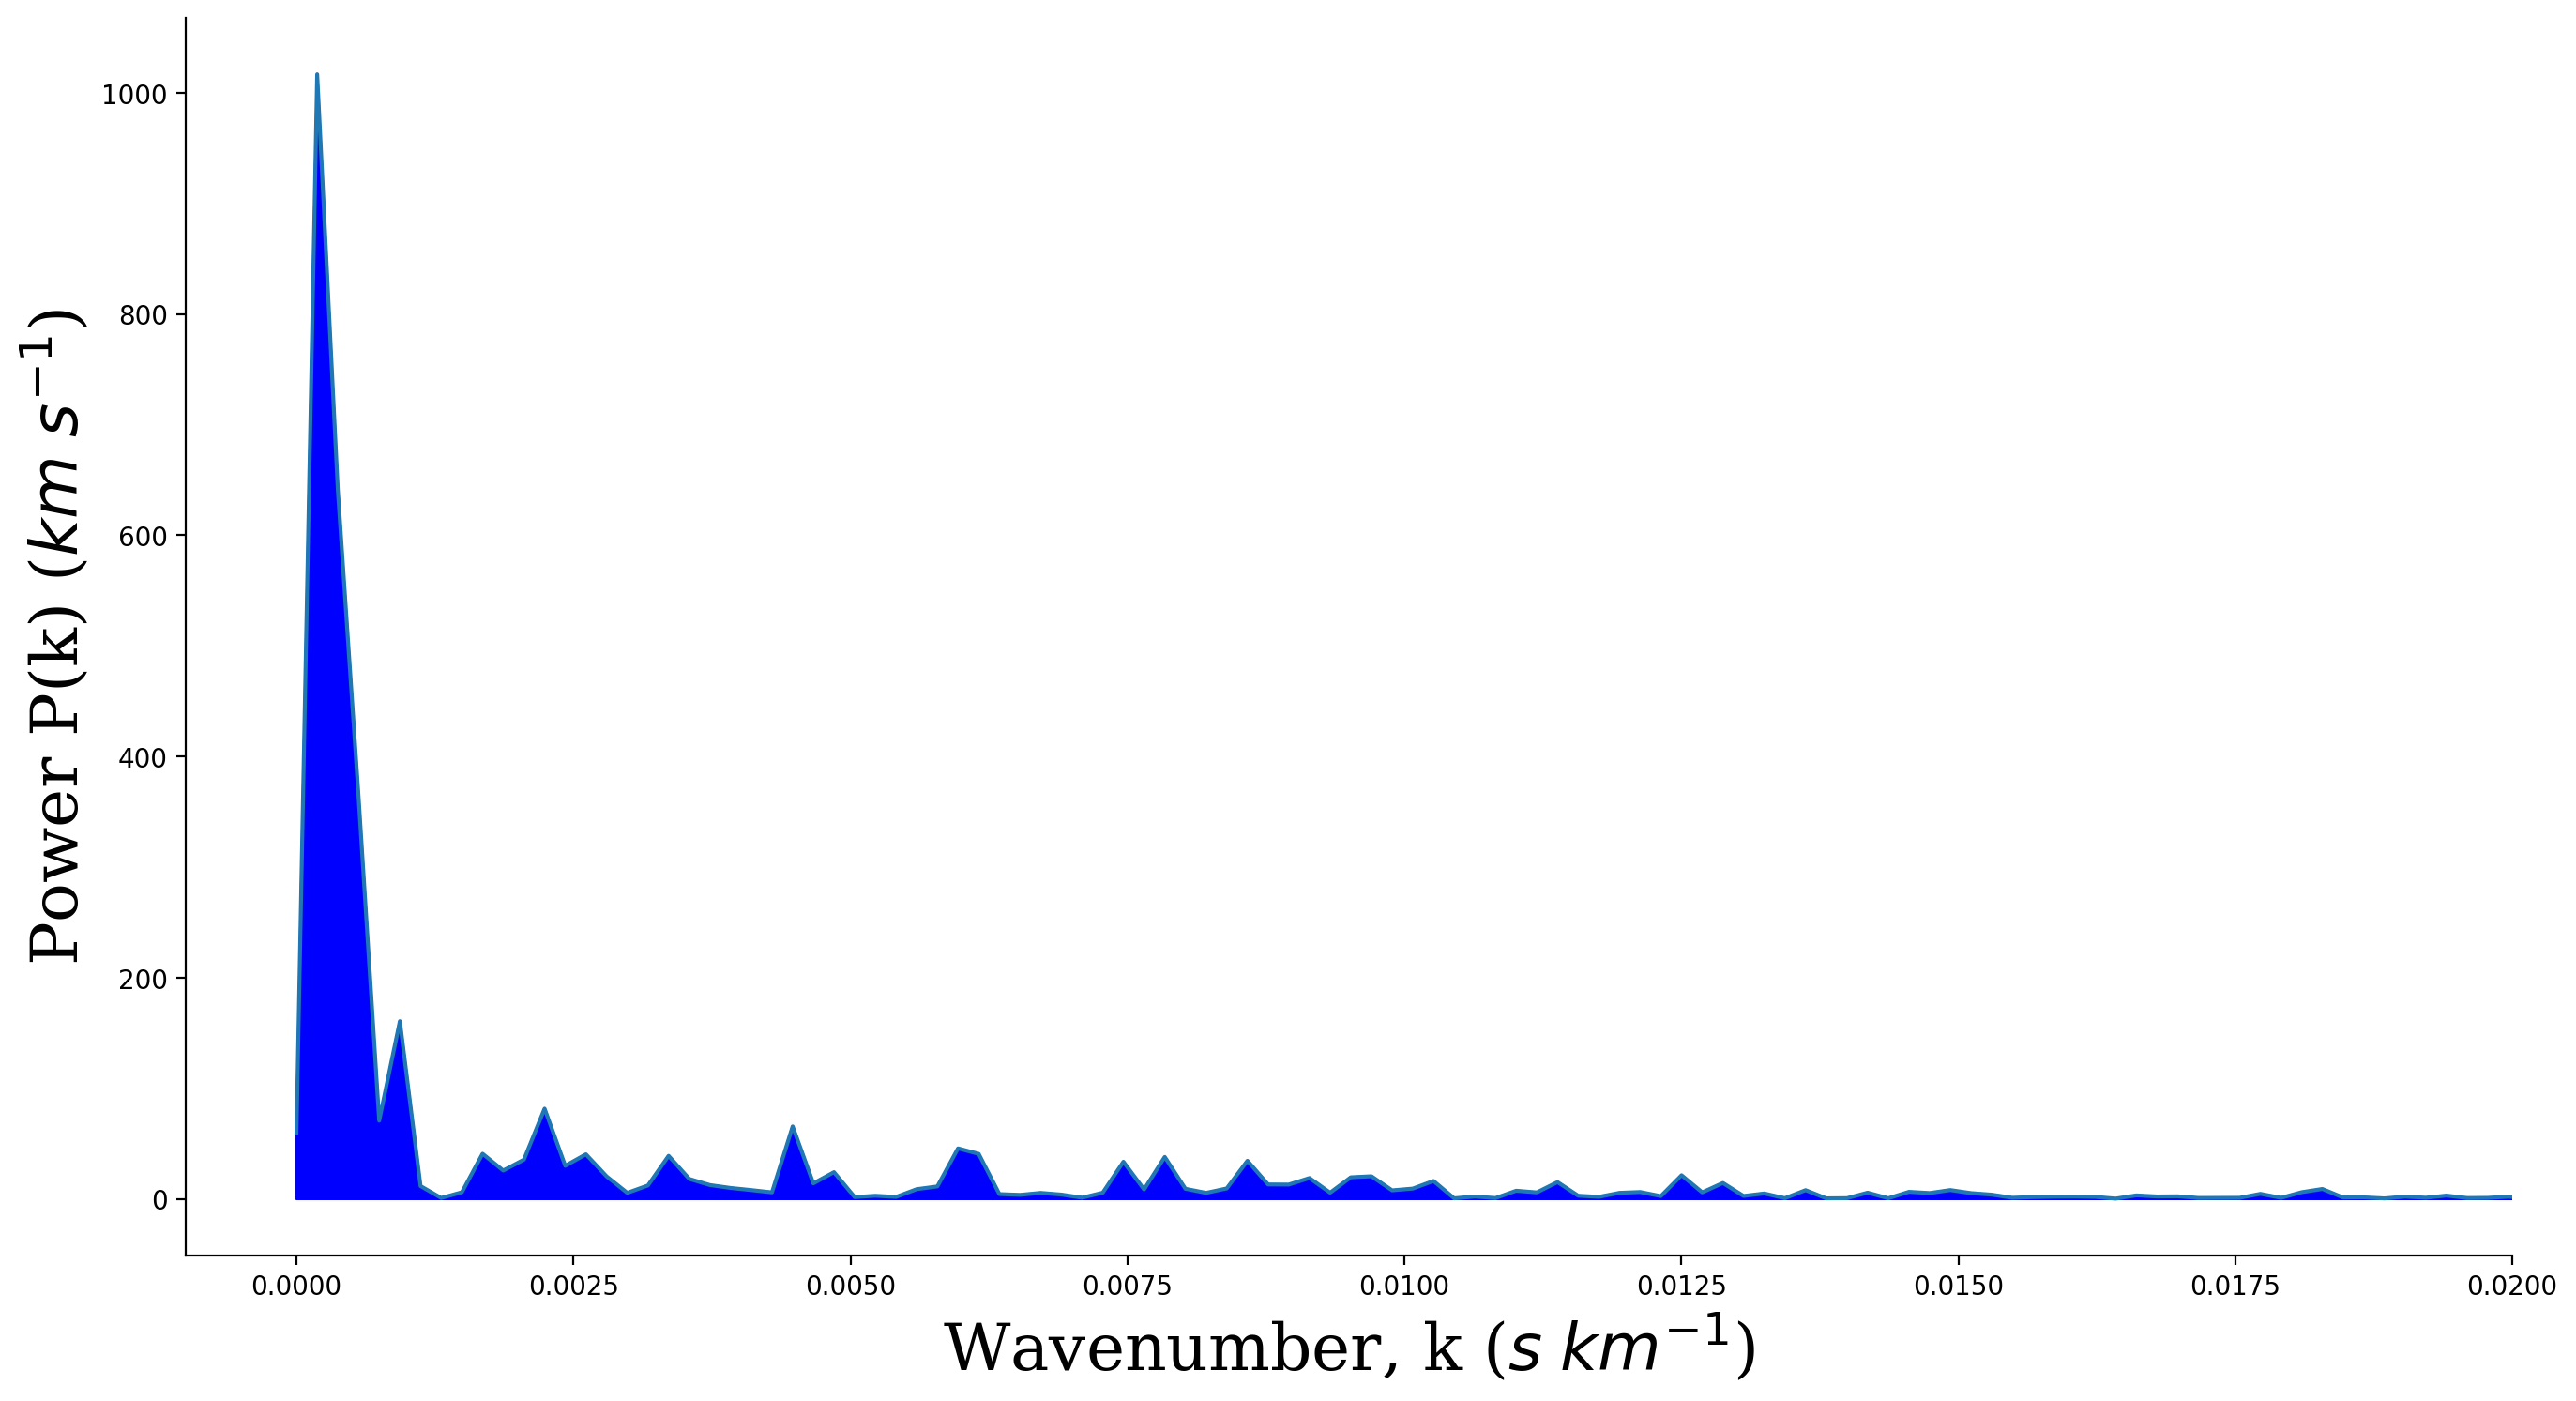

In [61]:
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

WL = 10**DELTA['LOGLAM']
D = DELTA['DELTA']
delta_lambda = 69

length_lambda = delta_lambda * len(D)
num_pixels = len(D)

delta_fourier = rfft(D)
raw_power = (delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2
wavenumber = 2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels)

fig, ax_main = plt.subplots(figsize=(16,8.56),dpi=200)

ax_main.plot(wavenumber,raw_power)
ax_main.set_xlim(-0.001,0.02)
ax_main.set_xlabel("Wavenumber, k ($s \;{km}^{-1}$)", style = 'normal', family = 'serif', size = 25)
ax_main.set_ylabel("Power P(k) ($km \;{s}^{-1}$)", style = 'normal', family = 'serif', size = 25)
ax_main.fill_between(wavenumber,raw_power,alpha = 1, color = 'blue')
plt.savefig('spectral dist', bbox_inches='tight', transparent=True,dpi=200)
plt.show()

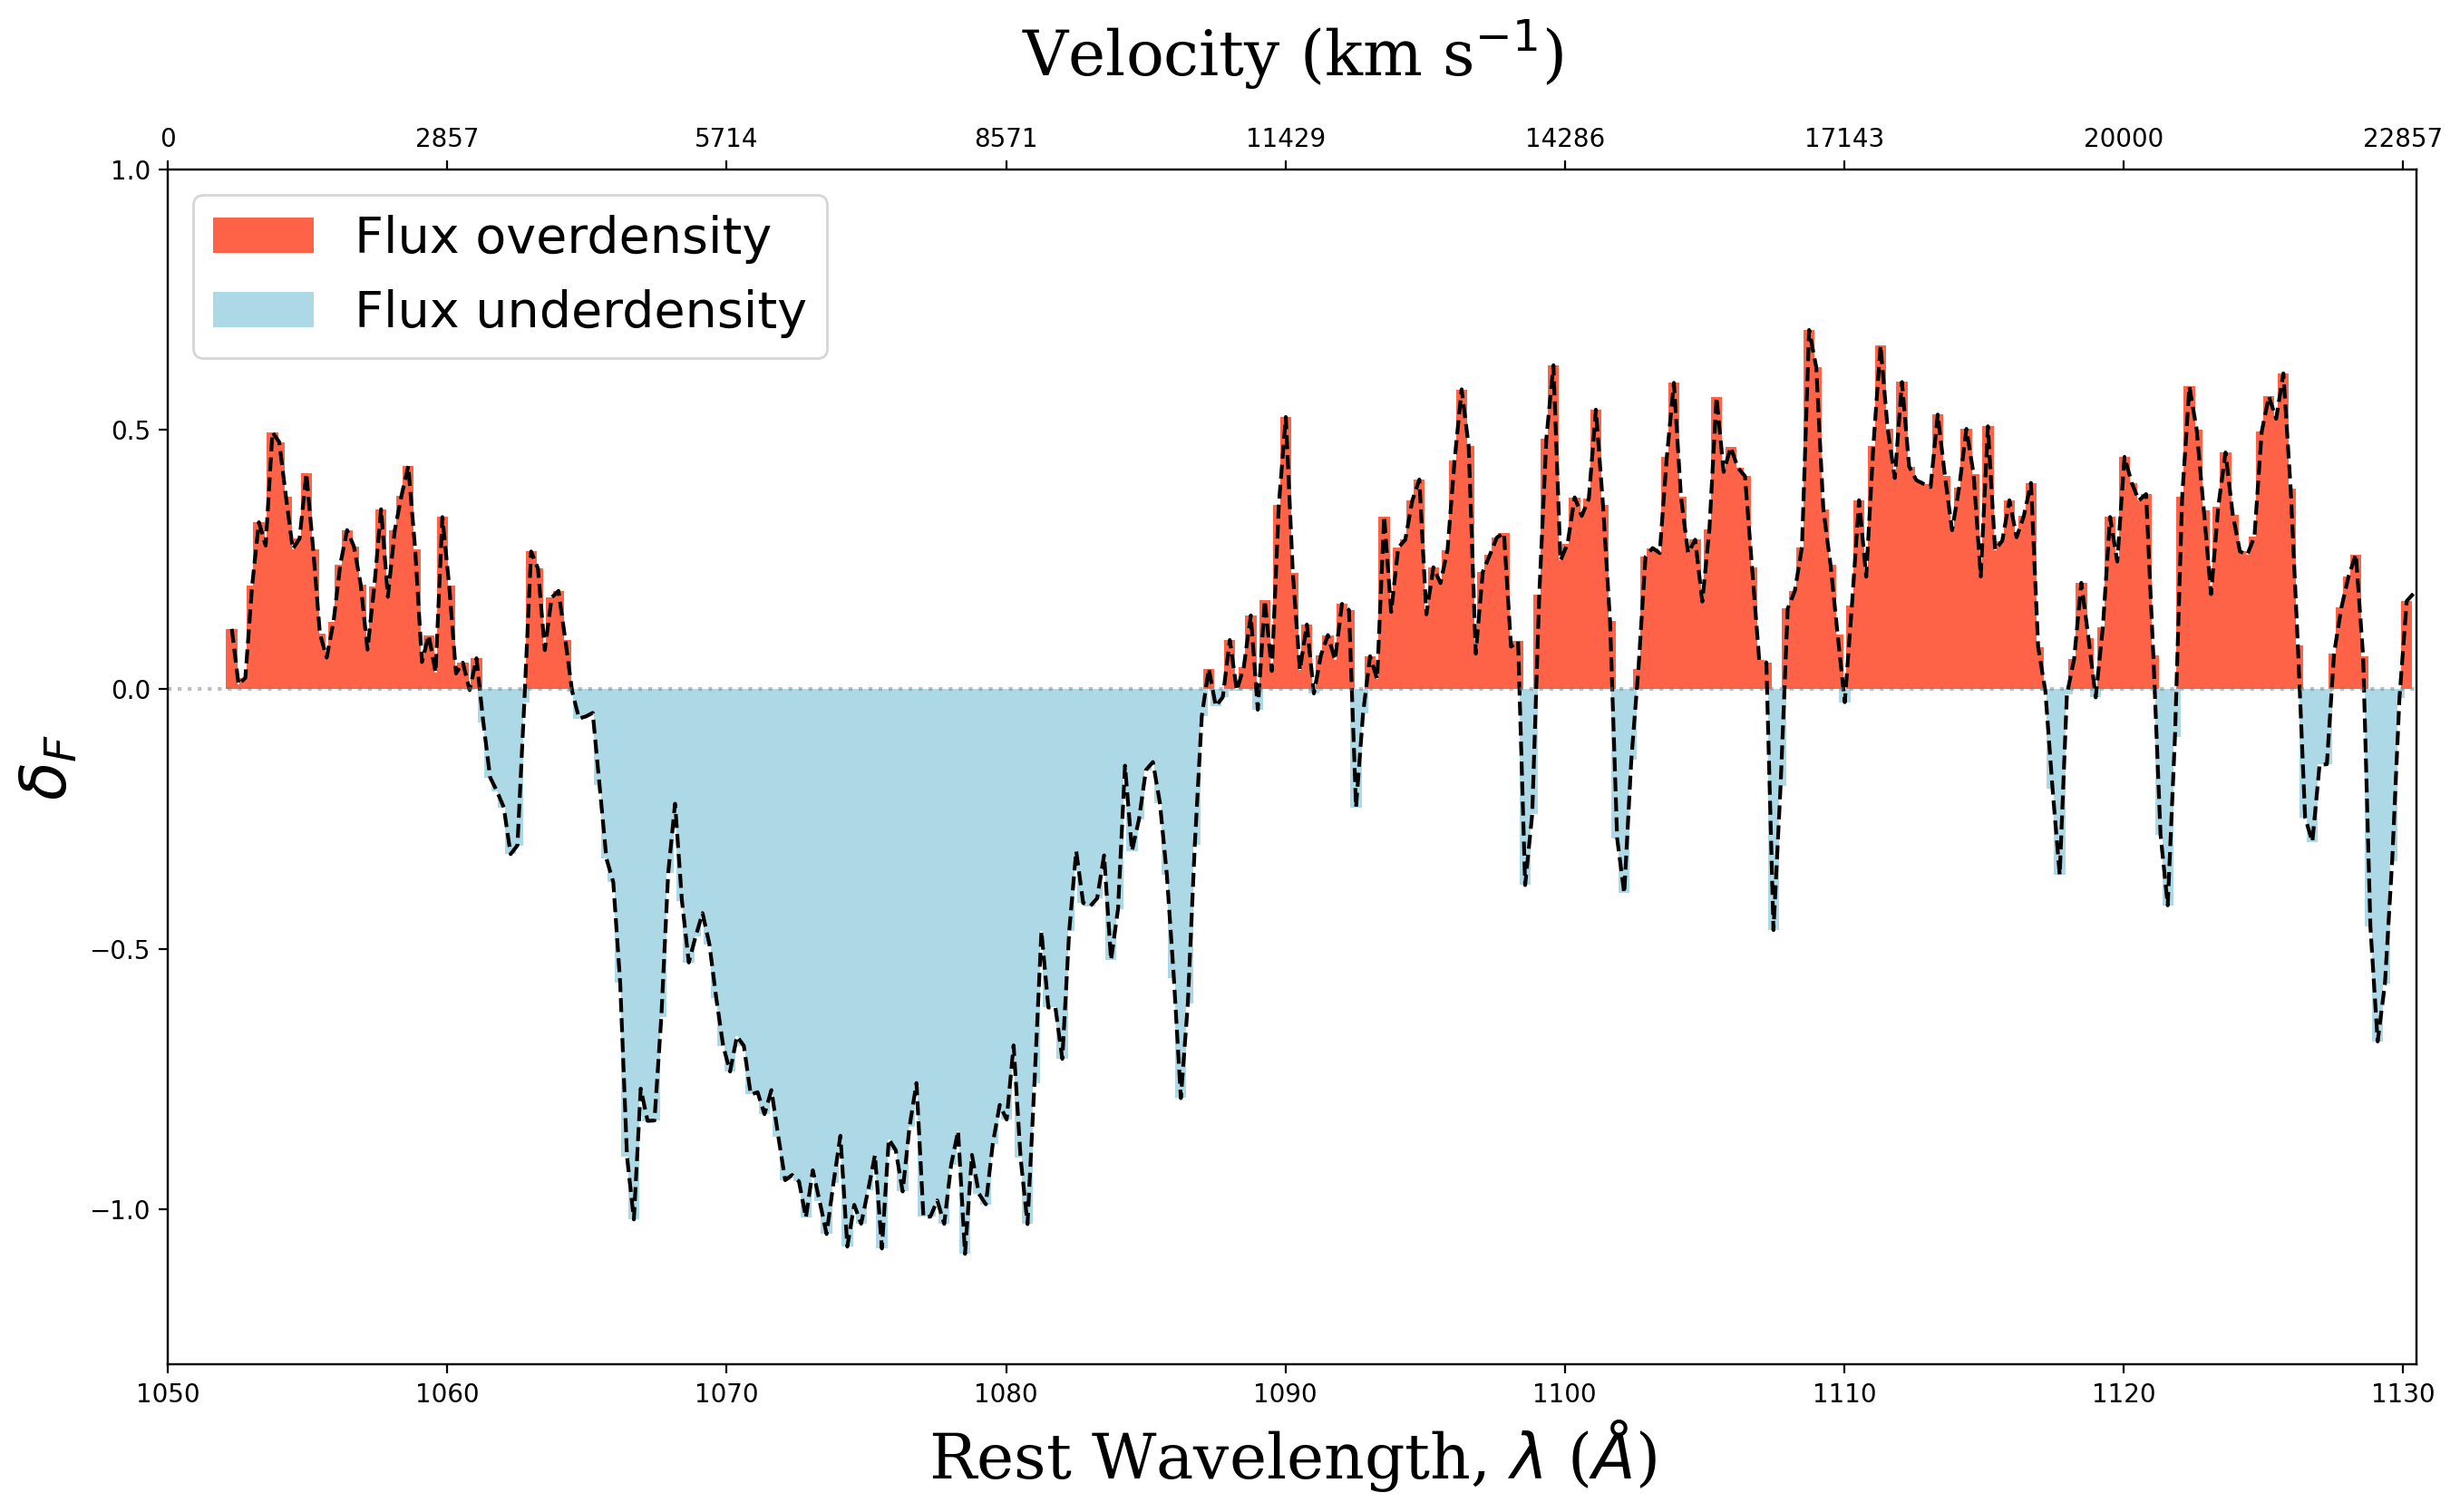

In [24]:
fig, ax_main = plt.subplots(figsize=(16,8.56),dpi=200)

D_V = np.array([WL[D>=0]/(2.853+1),D[D>=0],WL[D<0]/(2.853+1),D[D<0]],dtype=object) #Delta values

bar1 = ax_main.bar(D_V[0],D_V[1],color = 'tomato', width = 0.4, label = "Flux overdensity")
bar2 = ax_main.bar(D_V[2],D_V[3], color = 'lightblue', width = 0.4, label = "Flux underdensity")
ax_main.set_xlabel('Rest Wavelength, $\lambda$ ($\AA$)', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylabel('$\delta_{F}$', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylim(-1.3,1)
ax_main.set_xlim(1050,1130.5)
plt.plot(WL/(2.853+1), D, color = 'black', linestyle = "--")
plt.axhline(0,0, c='gray', alpha=0.5,ls =":", linewidth = 1.5)


ax2 = ax_main.twiny()
ax1Ticks = ax_main.get_xticks()   
ax2Ticks = ax1Ticks
def tick_function(input):
    V = []
    for r in range(len(input)):
        vel_unit = ((input[r]-1050)/1050)*300000
        V.append(vel_unit)
    return ["%.0f" % z for z in V]
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax_main.get_xbound())
ax2.set_xticklabels(tick_function(ax1Ticks))
ax2.set_xlabel(r'Velocity (km s$^{-1}$)', style = 'normal', family = 'serif', size = 25,labelpad=20)
ax_main.legend(loc ="upper left", fontsize = 20)
plt.savefig('Delta field', bbox_inches='tight', transparent=True,dpi=200)
plt.show()

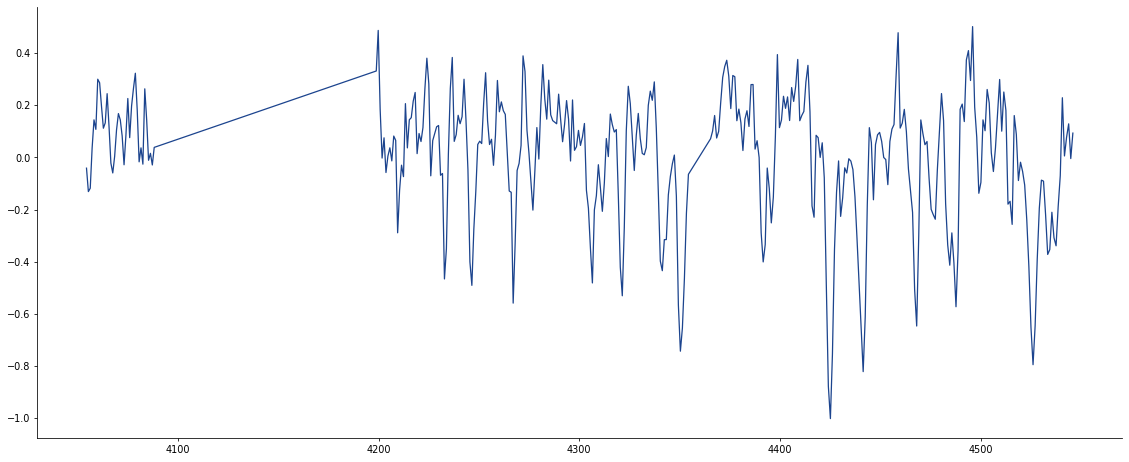

In [62]:
df_list = os.listdir('/home/holman/FILES/') # df_list = Downloaded files (Excluding catalogs)
df_list.sort()
df_list = np.array(df_list)
fi_f = np.char.find(df_list, "DLAcor", start=0, end=None)
delta_name = '/home/holman/FILES/' + str(df_list[fi_f>=0])[2:22]
delta_file = fits.open(delta_name)[275]
DELTA = Table.read(delta_file)
plt.figure(figsize=(20,8),dpi=70)
plt.plot(10**DELTA['LOGLAM'],DELTA['DELTA'],label = 'Delta',lw=1.3, color ='#1C448E')

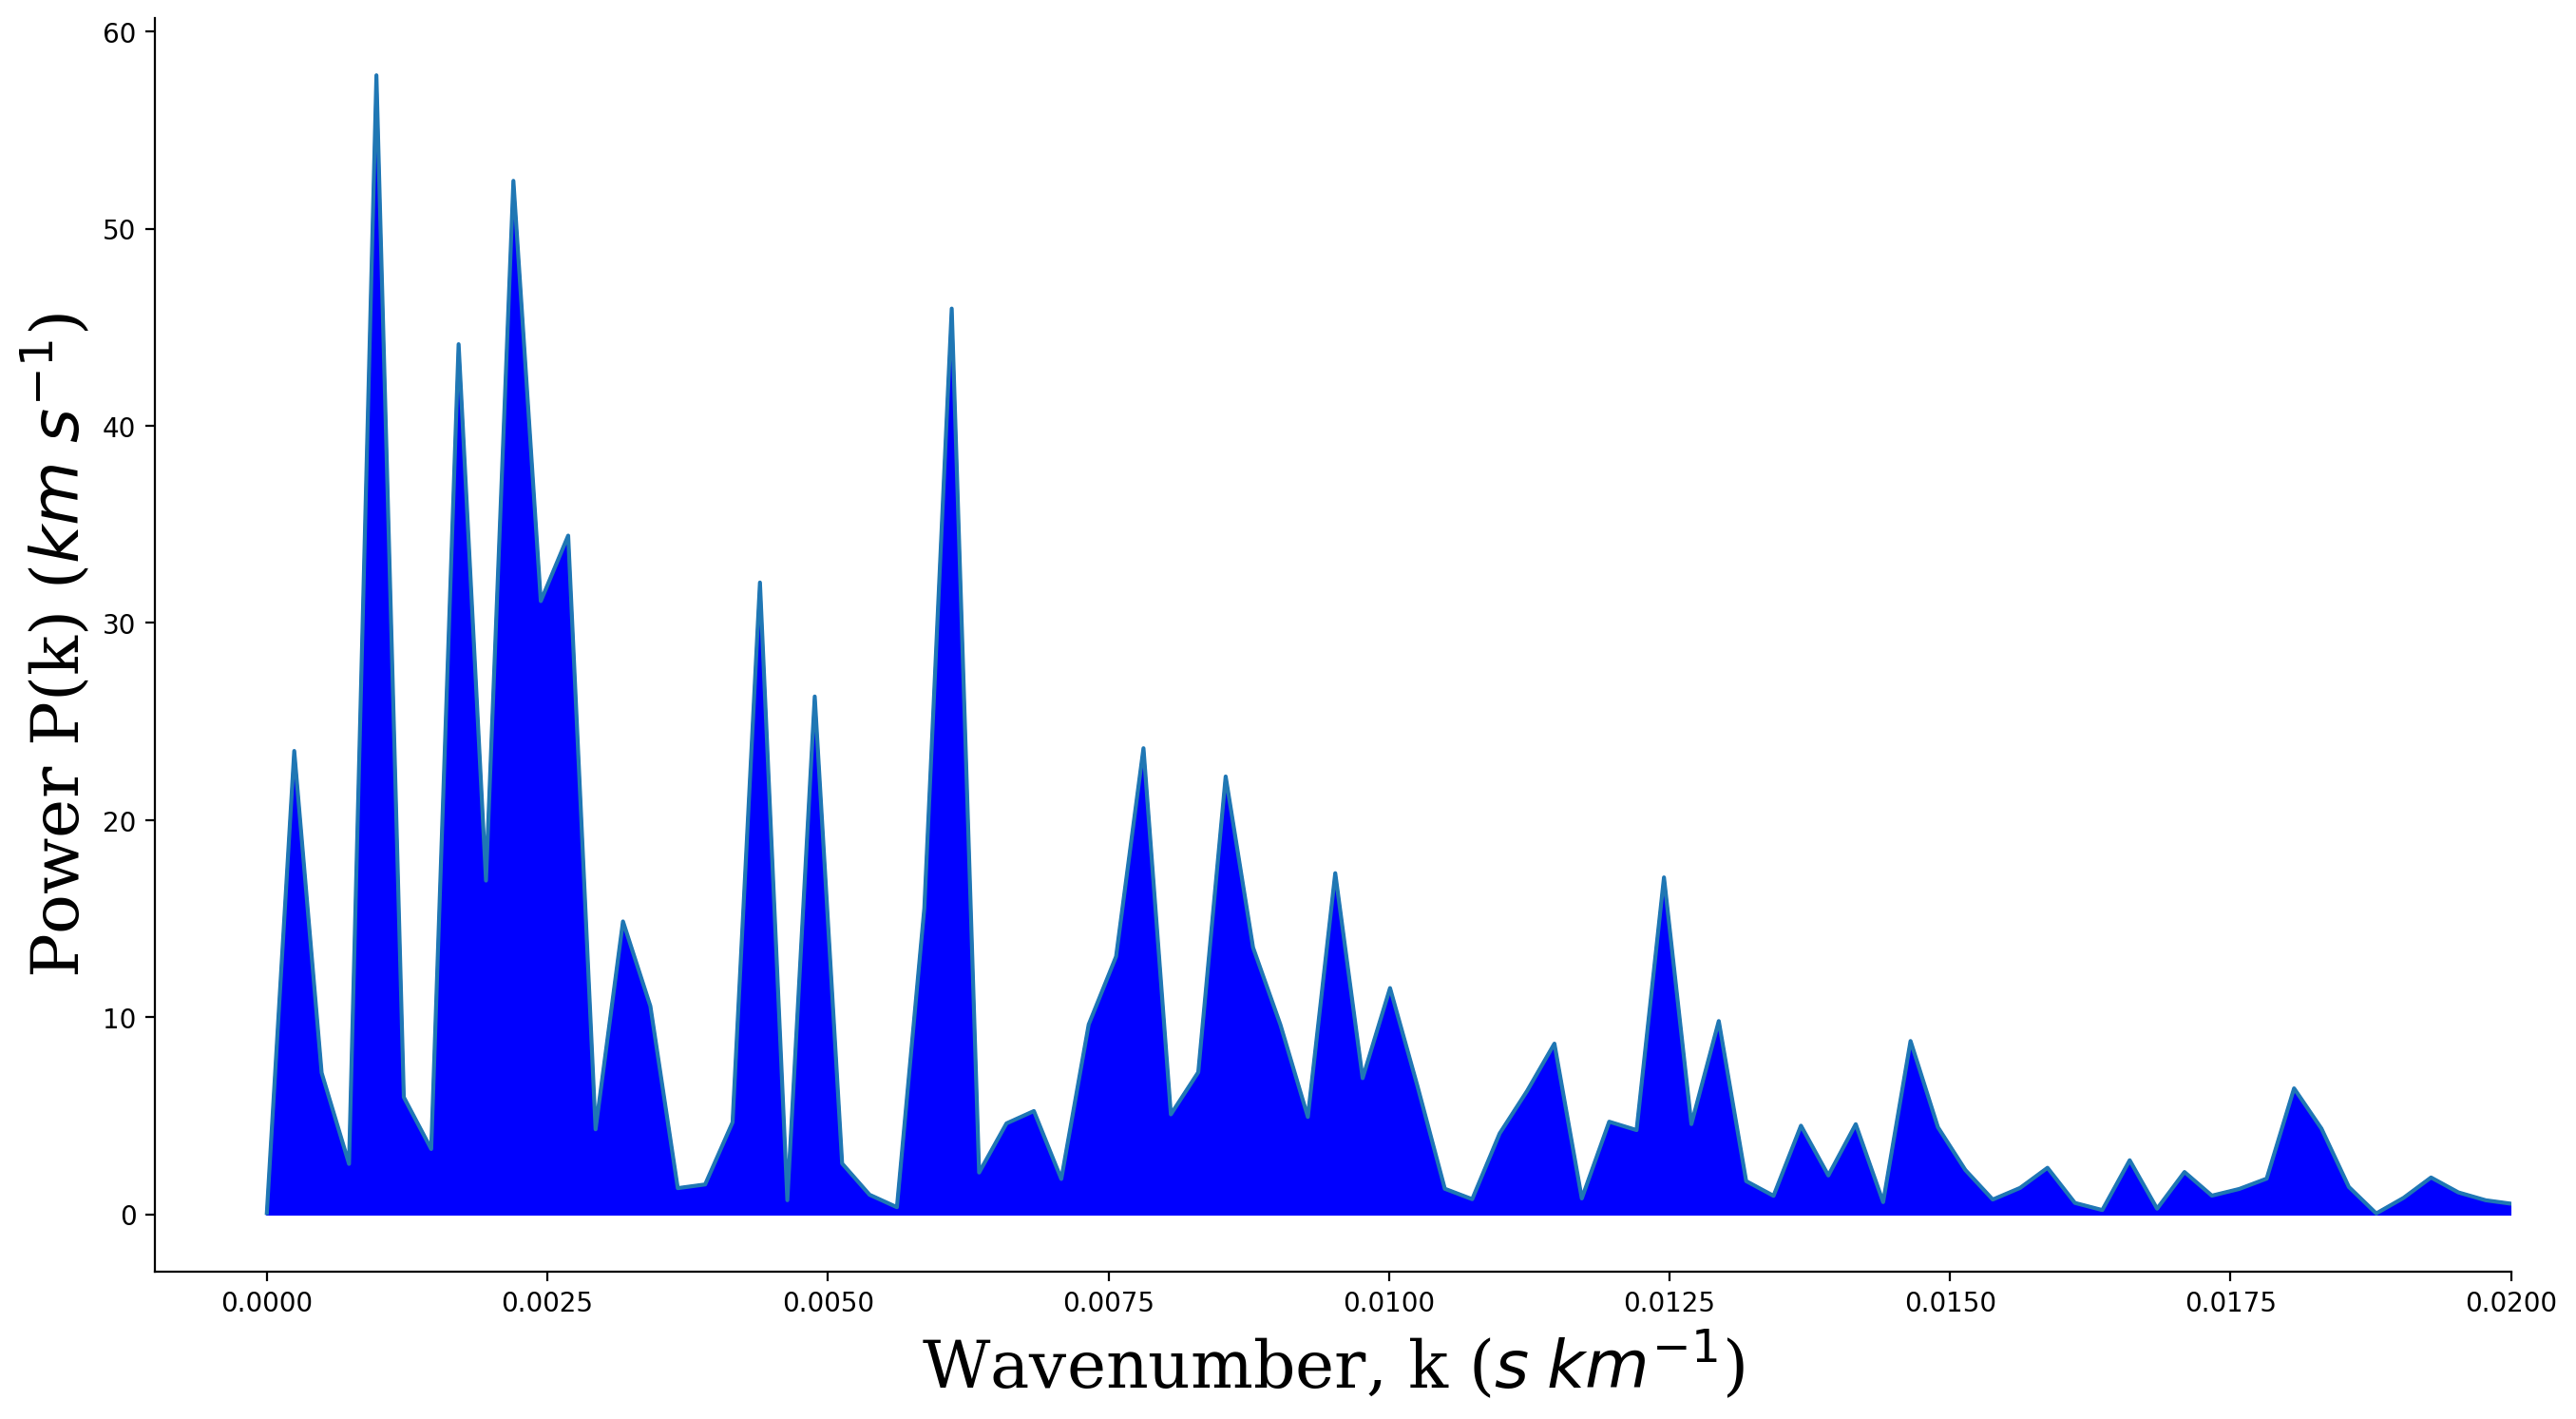

In [63]:
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

WL = 10**DELTA['LOGLAM']
D = DELTA['DELTA']
delta_lambda = 69

length_lambda = delta_lambda * len(D)
num_pixels = len(D)

delta_fourier = rfft(D)
raw_power = (delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2
wavenumber = 2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels)

fig, ax_main = plt.subplots(figsize=(16,8.56),dpi=200)

ax_main.plot(wavenumber,raw_power)
ax_main.set_xlim(-0.001,0.02)
ax_main.set_xlabel("Wavenumber, k ($s \;{km}^{-1}$)", style = 'normal', family = 'serif', size = 25)
ax_main.set_ylabel("Power P(k) ($km \;{s}^{-1}$)", style = 'normal', family = 'serif', size = 25)
ax_main.fill_between(wavenumber,raw_power,alpha = 1, color = 'blue')
plt.savefig('spectral dist', bbox_inches='tight', transparent=True,dpi=200)
plt.show()

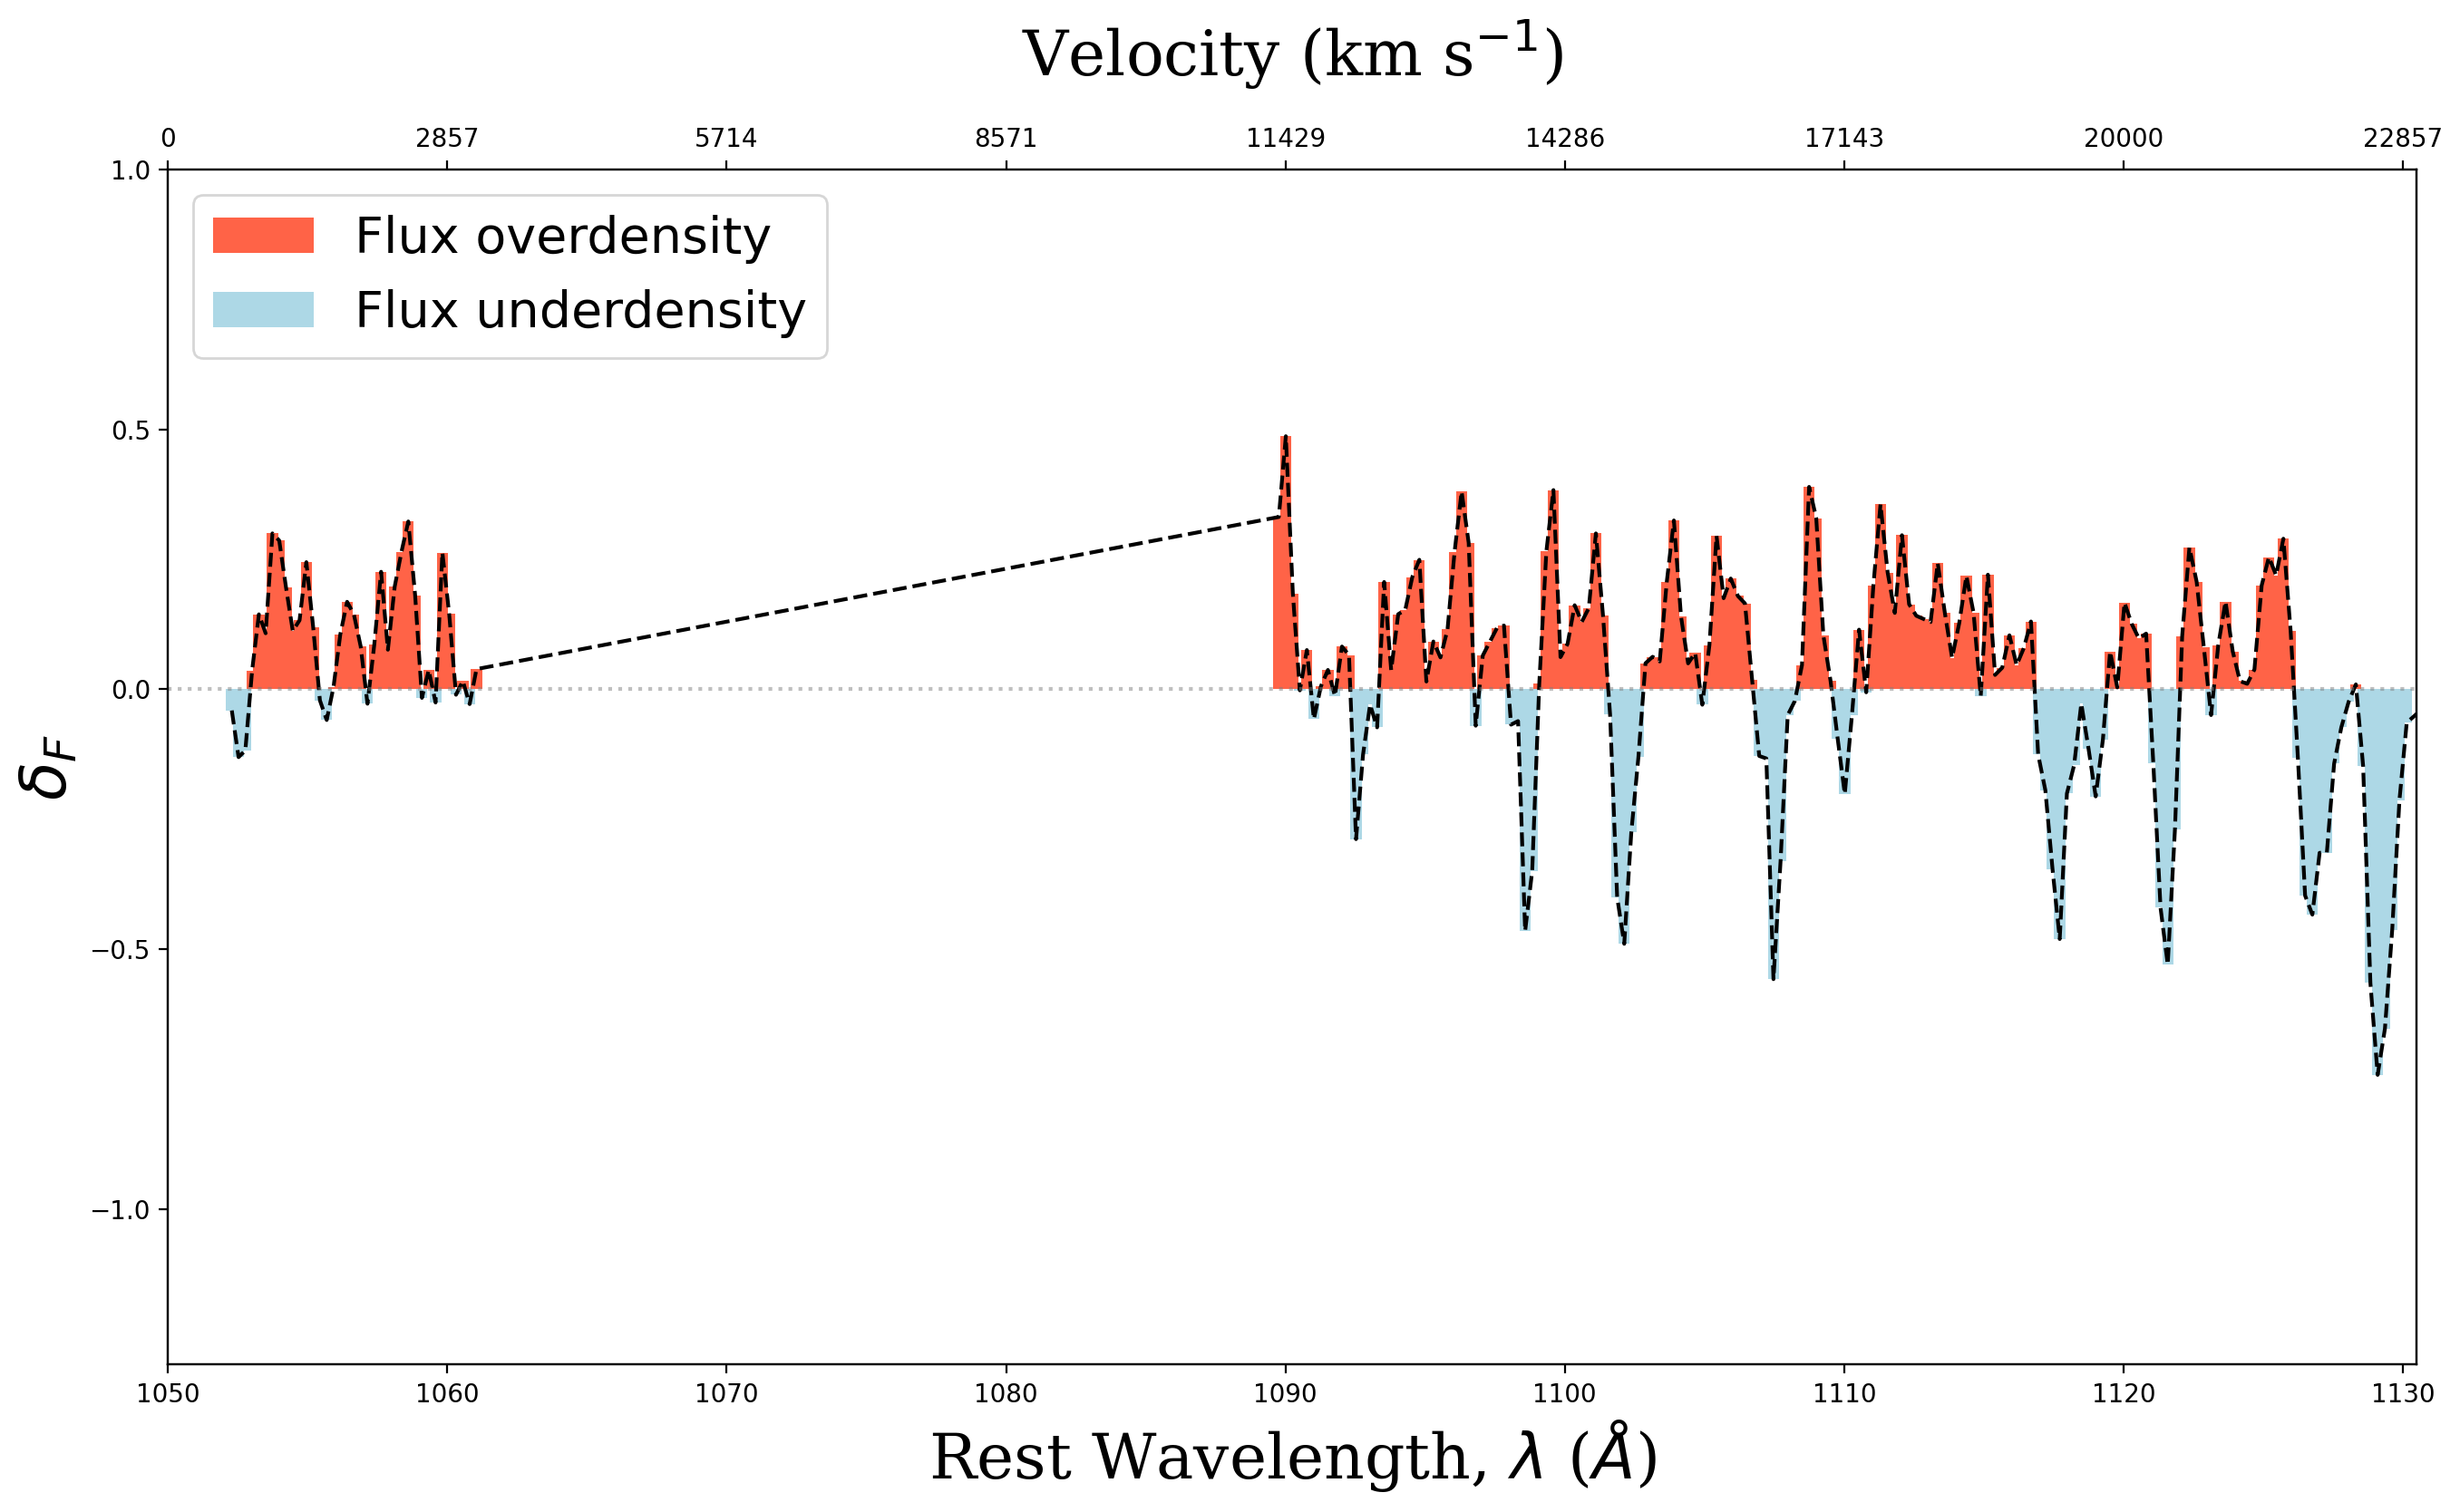

In [39]:
fig, ax_main = plt.subplots(figsize=(16,8.56),dpi=200)

D_V = np.array([WL[D>=0]/(2.853+1),D[D>=0],WL[D<0]/(2.853+1),D[D<0]],dtype=object) #Delta values

bar1 = ax_main.bar(D_V[0],D_V[1],color = 'tomato', width = 0.4, label = "Flux overdensity")
bar2 = ax_main.bar(D_V[2],D_V[3], color = 'lightblue', width = 0.4, label = "Flux underdensity")
ax_main.set_xlabel('Rest Wavelength, $\lambda$ ($\AA$)', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylabel('$\delta_{F}$', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylim(-1.3,1)
ax_main.set_xlim(1050,1130.5)
plt.plot(WL/(2.853+1), D, color = 'black', linestyle = "--")
plt.axhline(0,0, c='gray', alpha=0.5,ls =":", linewidth = 1.5)


ax2 = ax_main.twiny()
ax1Ticks = ax_main.get_xticks()   
ax2Ticks = ax1Ticks
def tick_function(input):
    V = []
    for r in range(len(input)):
        vel_unit = ((input[r]-1050)/1050)*300000
        V.append(vel_unit)
    return ["%.0f" % z for z in V]
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax_main.get_xbound())
ax2.set_xticklabels(tick_function(ax1Ticks))
ax2.set_xlabel(r'Velocity (km s$^{-1}$)', style = 'normal', family = 'serif', size = 25,labelpad=20)
ax_main.legend(loc ="upper left", fontsize = 20)
plt.savefig('Delta field', bbox_inches='tight', transparent=True,dpi=200)
plt.show()

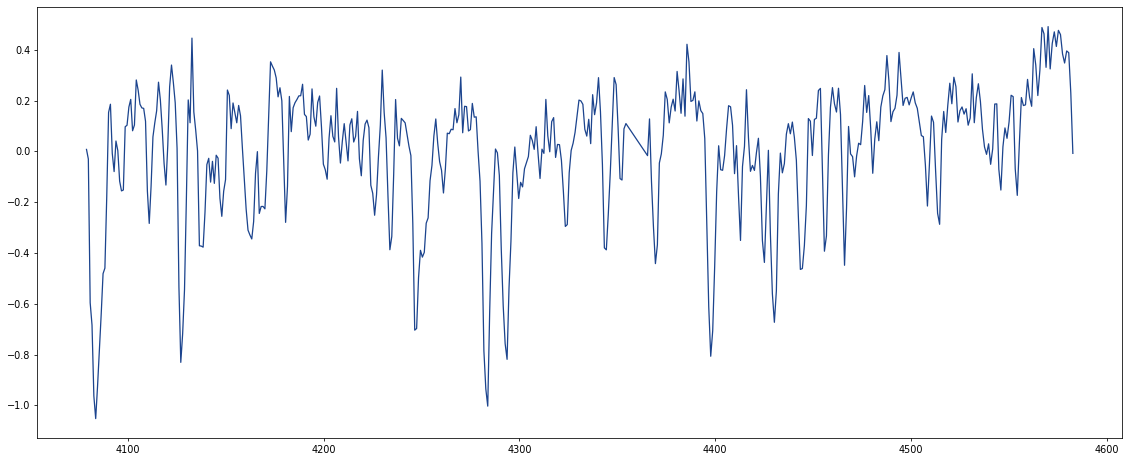

In [8]:
df_list = os.listdir('/home/holman/FILES/') # df_list = Downloaded files (Excluding catalogs)
df_list.sort()
df_list = np.array(df_list)
fi_f = np.char.find(df_list, "DLAfield", start=0, end=None)
delta_name = '/home/holman/FILES/' + str(df_list[fi_f>=0])[2:24]
delta_file = fits.open(delta_name)[337]
DELTA = Table.read(delta_file)
plt.figure(figsize=(20,8),dpi=70)
plt.plot(10**DELTA['LOGLAM'],DELTA['DELTA'],label = 'Delta',lw=1.3, color ='#1C448E')

WL = 10**DELTA['LOGLAM']
D = DELTA['DELTA']
delta_lambda = 0.8

length_lambda = delta_lambda * len(D)
num_pixels = len(D)

delta_fourier = rfft(D)
raw_power = (delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2
wavenumber = 2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels)


Text(0, 0.5, 'Raw power spectrum [Ang]')

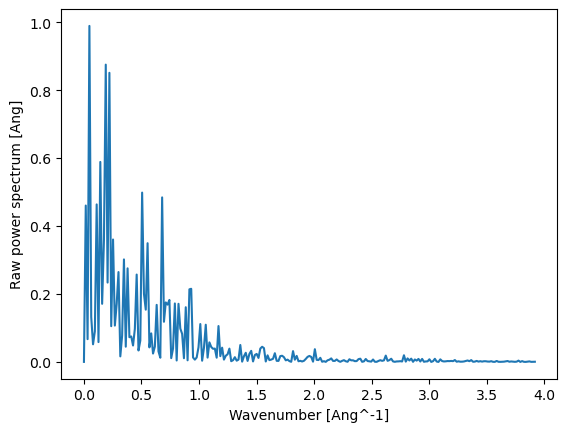

In [9]:
plt.plot(wavenumber,raw_power)
plt.xlabel("Wavenumber [Ang^-1]")
plt.ylabel("Raw power spectrum [Ang]")

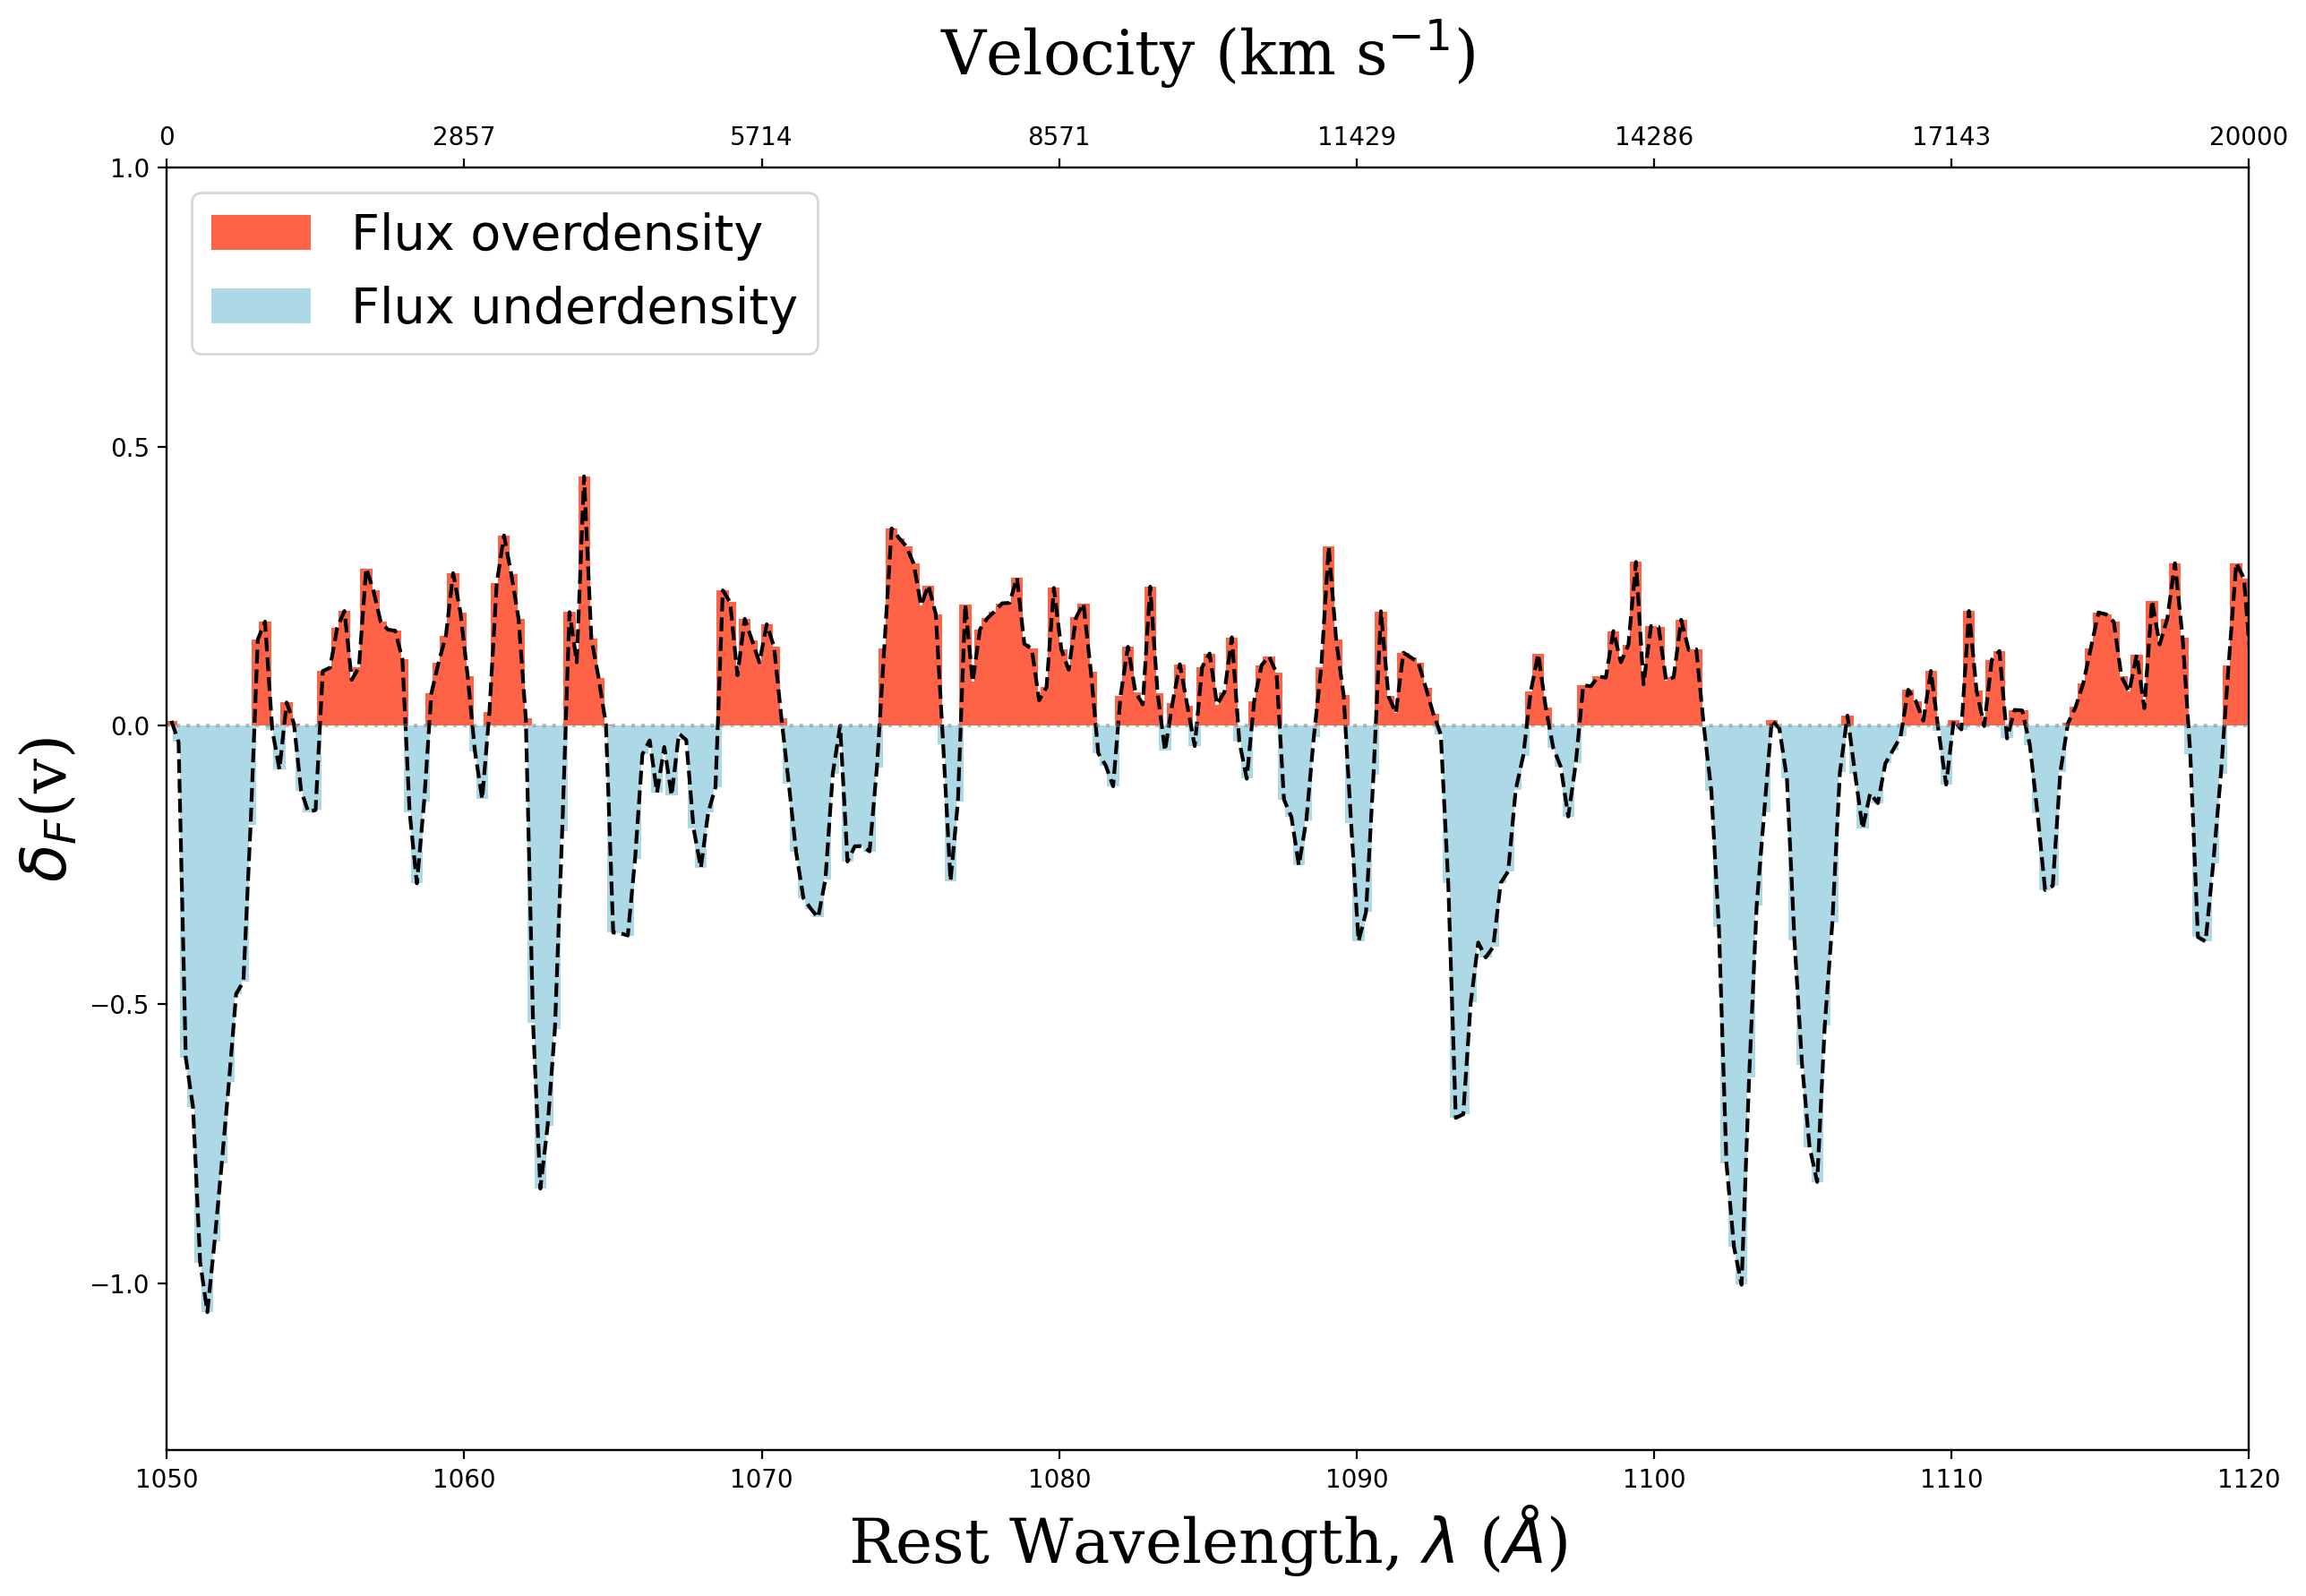

In [15]:
fig, ax_main = plt.subplots(figsize=(15,9.3),dpi=200)

D_V = np.array([WL[D>=0]/(2.884+1),D[D>=0],WL[D<0]/(2.884+1),D[D<0]],dtype=object) #Delta values

bar1 = ax_main.bar(D_V[0],D_V[1],color = 'tomato', width = 0.4, label = "Flux overdensity")
bar2 = ax_main.bar(D_V[2],D_V[3], color = 'lightblue', width = 0.4, label = "Flux underdensity")
ax_main.set_xlabel('Rest Wavelength, $\lambda$ ($\AA$)', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylabel('$\delta_{F}$(v)', style = 'normal', family = 'serif', size = 25)
ax_main.set_ylim(-1.3,1)
ax_main.set_xlim(1050,1120)
plt.plot(WL/(2.884+1), D, color = 'black', linestyle = "--")
plt.axhline(0,0, c='gray', alpha=0.5,ls =":", linewidth = 1.5)


ax2 = ax_main.twiny()
ax1Ticks = ax_main.get_xticks()   
ax2Ticks = ax1Ticks
def tick_function(input):
    V = []
    for r in range(len(input)):
        vel_unit = ((input[r]-1050)/1050)*300000
        V.append(vel_unit)
    return ["%.0f" % z for z in V]
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax_main.get_xbound())
ax2.set_xticklabels(tick_function(ax1Ticks))
ax2.set_xlabel(r'Velocity (km s$^{-1}$)', style = 'normal', family = 'serif', size = 25,labelpad=20)
ax_main.legend(loc ="upper left", fontsize = 20)
plt.savefig('Delta field', bbox_inches='tight', transparent=True,dpi=200)
plt.show()

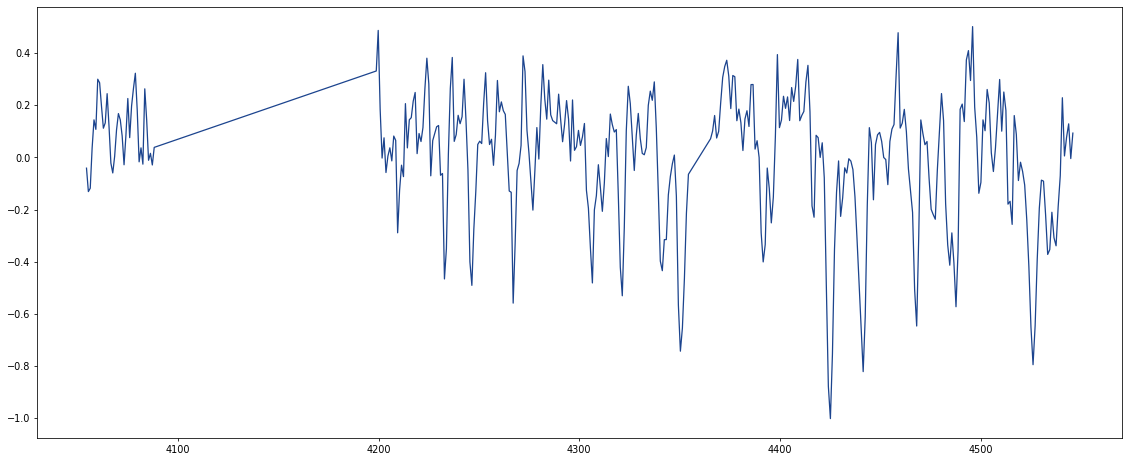

Text(0, 0.5, 'Raw power spectrum [Ang]')

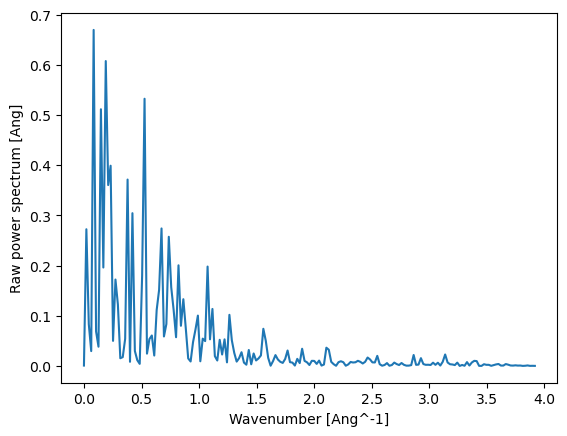

In [60]:
WL = 10**DELTA['LOGLAM']
D = DELTA['DELTA']
delta_lambda = 0.8

length_lambda = delta_lambda * len(D)
num_pixels = len(D)

delta_fourier = rfft(D)
raw_power = (delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2
wavenumber = 2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels)
     
plt.plot(wavenumber,raw_power)
plt.xlabel("Wavenumber [Ang^-1]")
plt.ylabel("Raw power spectrum [Ang]")

$$\Delta {v}_{i}=\frac{H(\bar{z})}{1+\bar{z}}\Delta{r}_{i}$$
$$=\frac{H(\bar{z})}{1+\bar{z}}\int^{{z}_{i}}_{\bar{z}}\frac{c\;d{z}^{'}}{H({z}^{'})}$$
$$=2c\Big(1-\sqrt{\frac{\bar{\lambda}}{{\lambda}_{i}}} \Big)$$

NameError: name 'arx_ov' is not defined

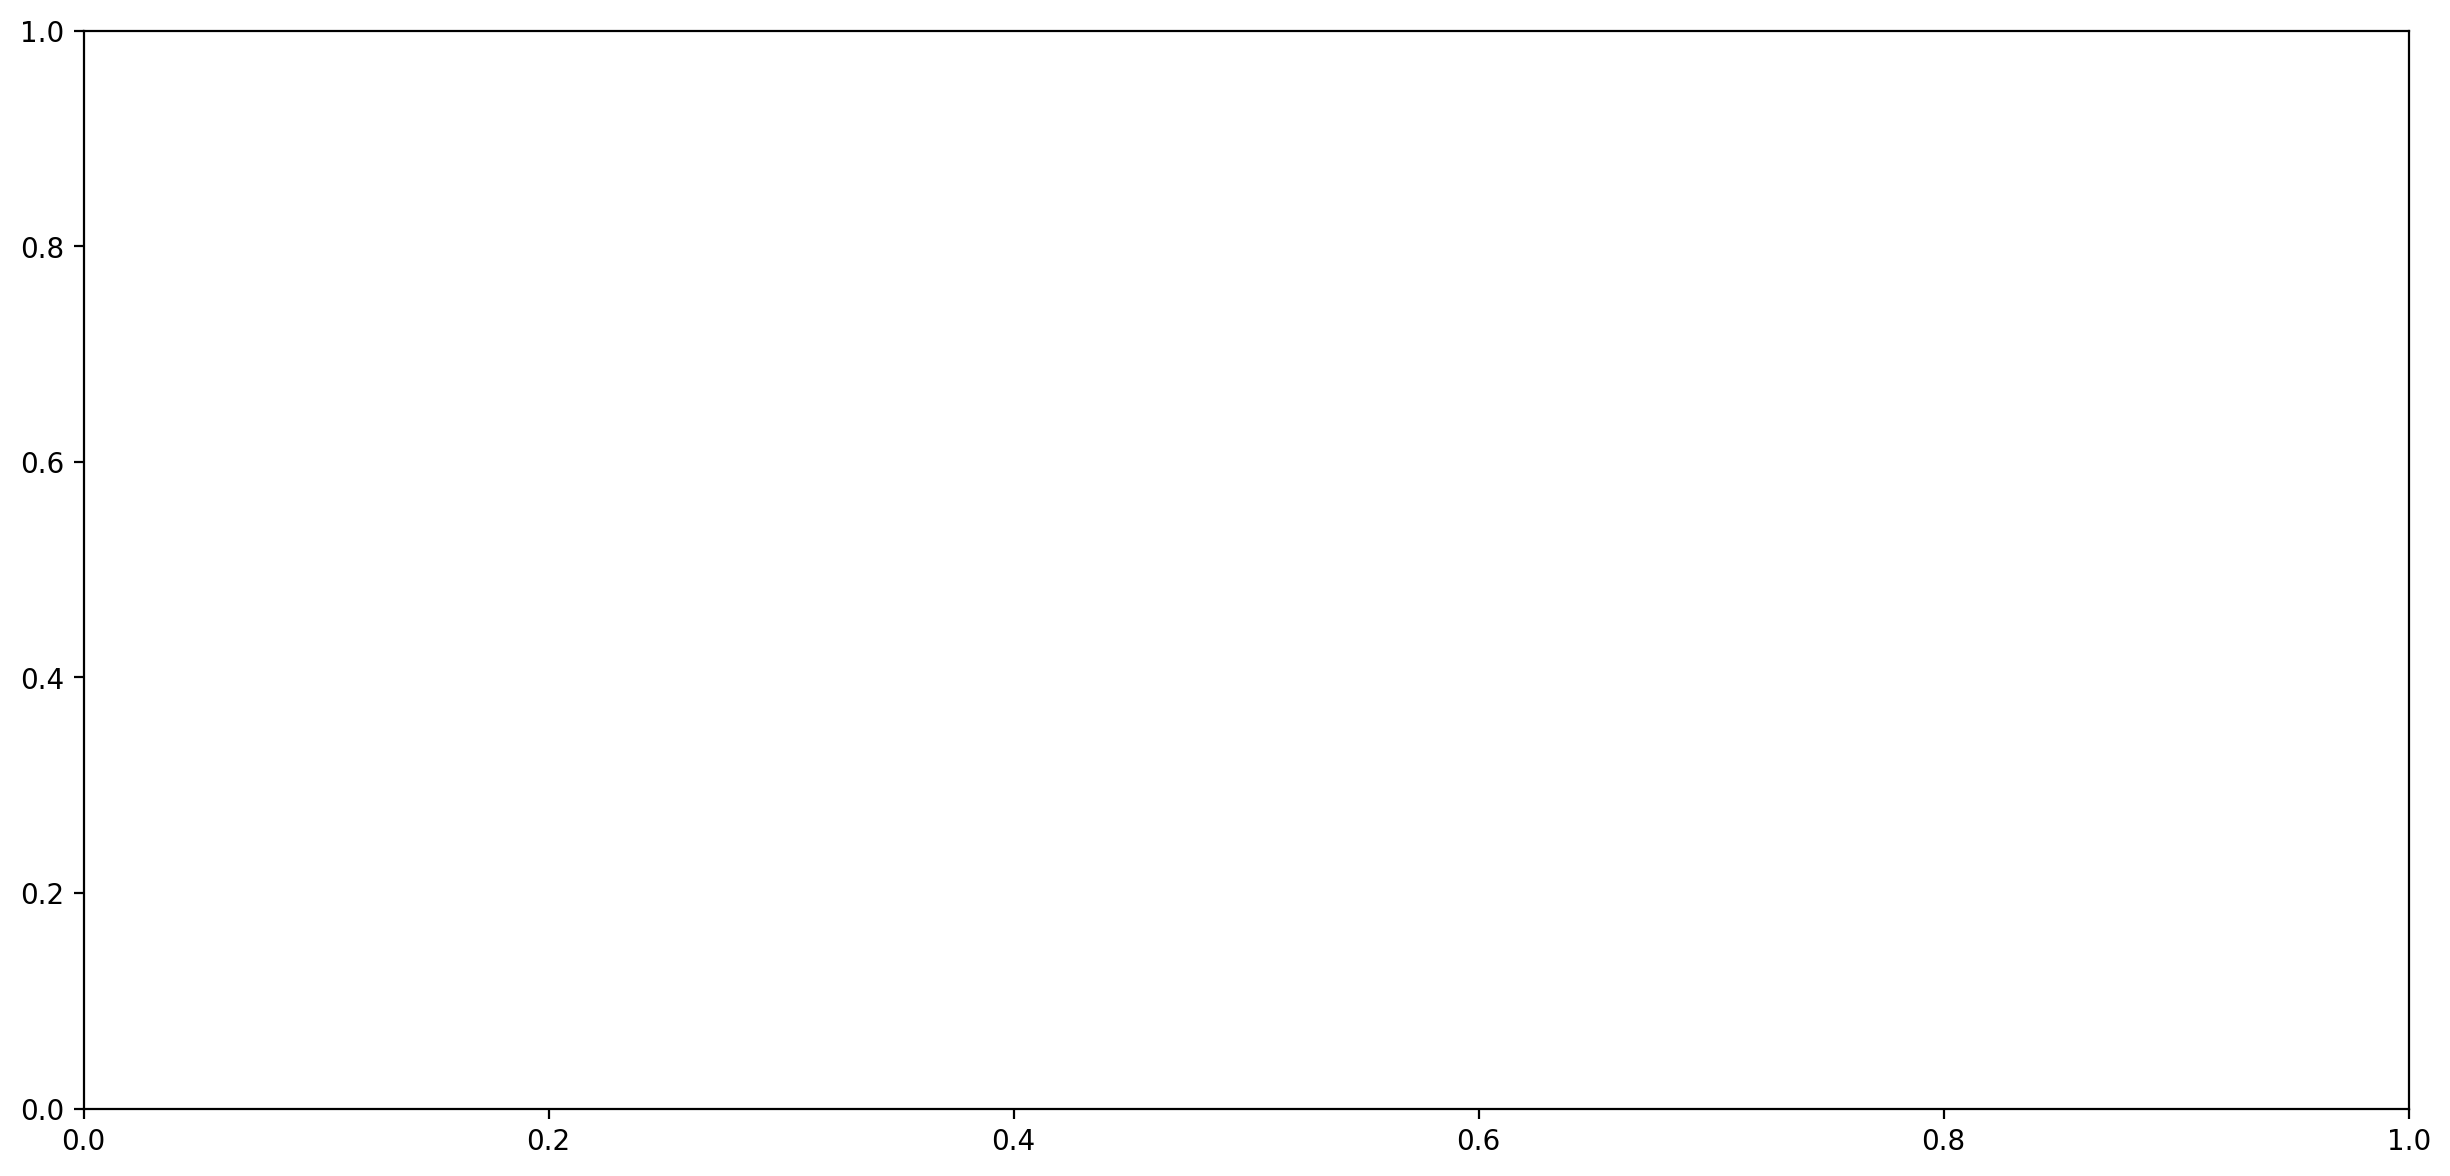

In [150]:
from astropy.cosmology import Planck18 as cosmo

def conv(z):
    H = cosmo.H(z)
    return H.value

z = np.linspace(0,5,16)

H = cosmo.H(2)
L = (1+2)*1216
cosmo.comoving_distance(10)

<Quantity 9636.28507946 Mpc>

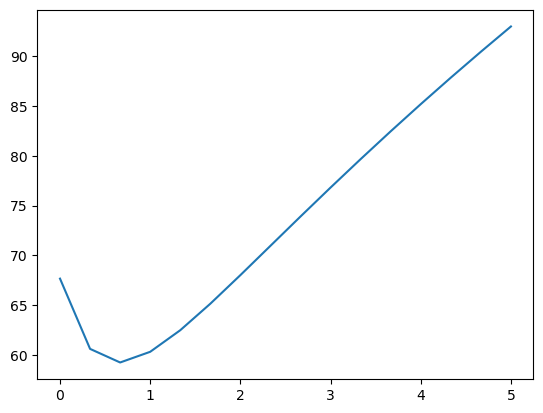

In [136]:
plt.plot(z,conv(z)/(1+z))

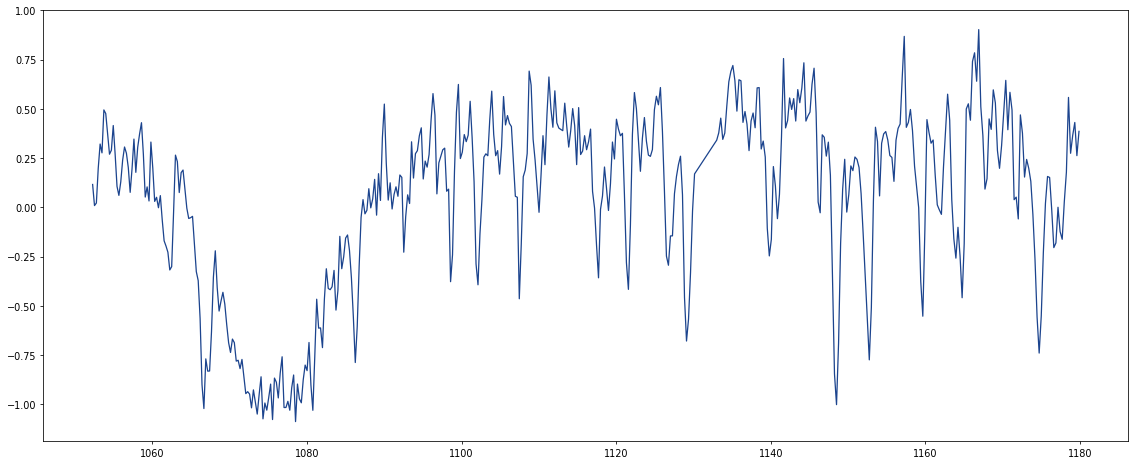

In [138]:
df_list = os.listdir('/home/holman/FILES/') # df_list = Downloaded files (Excluding catalogs)
df_list.sort()
df_list = np.array(df_list)
fi_f = np.char.find(df_list, "DLAnocor", start=0, end=None)
delta_name = '/home/holman/FILES/' + str(df_list[fi_f>=0])[2:24]
delta_file = fits.open(delta_name)[276]
DELTA = Table.read(delta_file)
plt.figure(figsize=(20,8),dpi=70)
plt.plot(10**DELTA['LOGLAM']/(2.853+1),DELTA['DELTA'],label = 'Delta',lw=1.3, color ='#1C448E')

In [152]:
for x in range(7):
    print(10**DELTA['LOGLAM'][x+1]-10**DELTA['LOGLAM'][x])



0.9336776380100673
0.9338926499845002
0.9341077114722793
0.9343228224865925
0.9345379830369893
0.9347531931362028
0.9349684527942372


In [111]:
conv(0)

67.66

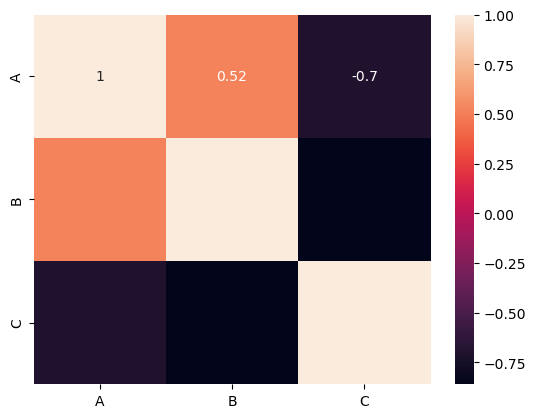

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'A': [45, 37, 42, 35, 39],
        'B': [38, 31, 26, 28, 33],
        'C': [10, 15, 17, 21, 12]
        }

df = pd.DataFrame(data)

corr_matrix = df.corr()

sn.heatmap(corr_matrix, annot=True)
plt.show()